## COVID-19: Paraíba 2020-2022

### Integrantes:

* [João Henrique de Araújo Pereira](https://github.com/joaoh224488)&nbsp;&nbsp;&nbsp;&nbsp;|&nbsp;&nbsp;&nbsp;Matrícula: 20210026705 
* [Maria Raquel Souza Martinez](https://github.com/maria-raquel)&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|&nbsp;&nbsp; Matrícula: 20200025900
* [Maxwel de Andrade Barbosa](https://github.com/maxbarbosa)&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|&nbsp;&nbsp; Matrícula: 20210067083



<p align="center"><img src="https://www.camara.leg.br/midias/image/2020/10/img20201022140139807-768x512.jpg" width="70%" height="70%"/></p>

Fonte: https://www.camara.leg.br/midias/image/2020/10/img20201022140139807-768x512.jpg

## Introdução e objetivos

### Objetivo geral:



### Objetivos específicos:

### Bibliotecas utilizadas:

As bibliotecas usadas no projeto estão contidas no arquivo `requirements.txt` presente no diretório raiz [deste trabalho](https://github.com/maxbarbosa/data-science-final-project).

Elas podem ser instaladas através da execução da instrução abaixo dentro do programa de linha de comando do seu sistema operacional:

    pip install -r requirements.txt


### Importação das bibliotecas e carregamento dos dados:

In [90]:
import pandas as pd
import seaborn as sns
import numpy as np
import plotly.express as px
import fix_vaxs
from matplotlib import pyplot as plt
from scipy.stats import norm
from sklearn.cluster import KMeans
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style = "ticks", rc = custom_params)

vax_df      =  pd.read_csv("datasets/dados_vacinacao.csv")
casos_br_df =  pd.read_csv("datasets/dados_br.csv")
casos_pb_df =  pd.read_csv("datasets/dados_pb.csv")

### Dados:

Para nossas análises, usamos três datasets.

O primeiro tem informações sobre todas as doses individuais de vacinas contra a COVID-19 aplicadas pelo SUS no estado da Paraíba, disponibilizado pelo Ministério da Saúde no site [Open Data SUS](https://opendatasus.saude.gov.br/dataset/covid-19-vacinacao). Cada entrada desse dataset tem informações sobre o paciente (como idade, sexo e etnia) e sobre a dose (como a fabricante e o município de aplicação). Para mais informações, temos um [dicionário](https://github.com/maxbarbosa/data-science-final-project/blob/main/datasets/dicionario-de-dados-vacinacao.pdf) neste repositório explicando todas as colunas.

In [91]:
vax_df.head(3)

,paciente_idade,paciente_dataNascimento,paciente_enumSexoBiologico,paciente_racaCor_codigo,paciente_racaCor_valor,paciente_endereco_nmMunicipio,paciente_endereco_cep,estabelecimento_municipio_nome,vacina_grupoAtendimento_codigo,vacina_grupoAtendimento_nome,vacina_categoria_codigo,vacina_categoria_nome,vacina_dataAplicacao,vacina_descricao_dose,vacina_codigo,vacina_nome,paciente_id
0,44,1977-04-18,M,1,BRANCA,ARAPIRACA,57510,PATOS,912,Médico,9,Trabalhadores de Saúde,2021-11-11,Reforço,87,COVID-19 PFIZER - COMIRNATY,f9495cb04daf5adb495d22c9c88b31883f191fb762ab27...
1,5,2016-11-18,M,1,BRANCA,PARELHAS,None,CAMPINA GRANDE,207,Pessoas de 5 a 11 anos,0,NaN,2022-02-07,1ª Dose,99,COVID-19 PEDIÁTRICA - PFIZER COMIRNATY,52288faace8c986872faca7101868ae8a23fefd435cd51...
2,39,1982-01-23,F,99,SEM INFORMACAO,CAMPINA GRANDE,58410,CAMPINA GRANDE,201,Pessoas de 18 a 64 anos,2,Faixa Etária,2021-07-16,1ª Dose,85,COVID-19 ASTRAZENECA/FIOCRUZ - COVISHIELD,0ffaed327aac7fe8abf0b35471b0b1fa60f9fc48ff7d9c...



O segundo dataset usado tem informações sobre a pandemia da COVID-19 em todos os municípios da Paraíba. Cada linha representa um município paraibano e cada coluna tem informações sobre a pandemia neste município. Elas são:

* city (nome do município)
* confirmed (quantidade bruta de casos confirmados)
* deaths (quantidade bruta de mortes pela COVID-19)
* estimated_population (população estimada do município)
* confirmed_per_100k_inhabitants (casos confirmados a cada 100 mil habitantes)
* death_rate (taxa de mortalidade, razão entre as quantidades brutas de casos e de mortes)

Esse dataset foi encontrado no site [Brasil IO](https://brasil.io/covid19/PB/), um blog de programadores voluntários que coletavam e organizavam os dados da COVID-19 de cada Secretária Estadual de Saúde e compilavam em uma base de dados única e de fácil acesso. No entanto, esse dataset parou de ser atualizado, e os dados mais recentes da pandemia na Paraíba são do dia 22/08/2021.

Por fim, o terceiro dataset usado é semelhante ao segundo, encontrado também no site Brasil IO, porém ele inclui todos os municípios brasileiros, ao contrário de só os paraibanos. Ele foi utilizado para fins de comparação entre o cenário da pandemia na Paraíba e o cenário nacional.

In [92]:
casos_br_df.head(3)

,date,state,city,place_type,confirmed,confirmed_per_100k_inhabitants,deaths,death_rate,estimated_population
0,2021-08-22,AC,Acrelândia,city,1792,11568.7540,37,0.0206,15490
1,2021-08-22,AC,Assis Brasil,city,1815,24090.7884,24,0.0132,7534
2,2021-08-22,AC,Brasiléia,city,2980,11160.2127,43,0.0144,26702


## Pré-processamento

O dataset disponibilizado pela plataforma [Open Data SUS](https://opendatasus.saude.gov.br/dataset/covid-19-vacinacao/resource/10aed154-04c8-4cf4-b78a-8f0fa1bc5af4) possui algumas células com mais de um valor (contém vírgulas a mais), que ocasionam um erro de leitura do arquivo `.csv` no Python. Só é possível corrigí-lo através de um processo pseudo-manual, cujo passo a passo está detalhado [nesse arquivo](https://github.com/maxbarbosa/data-science-final-project/tree/main/datasets#readme) do repositório.


O dataset original possui 2.806.755 linhas e 32 colunas. Dessas colunas, removemos 15 que não foram utilizadas nessa análise.

Tais colunas foram removidas através do código explicitado abaixo:


```python
import pandas as pd
df = pd.read_csv('dados_vacinacao.csv')

df = df.drop(
        ['document_id',  
        'paciente_endereco_coIbgeMunicipio', 
        'paciente_endereco_coPais',
        'paciente_endereco_nmPais',
        'paciente_endereco_uf', 
        'paciente_nacionalidade_enumNacionalidade', 
        'estabelecimento_valor',
        'estabelecimento_razaoSocial', 
        'estalecimento_noFantasia',
        'estabelecimento_municipio_codigo', 
        'estabelecimento_uf', 
        'vacina_fabricante_nome',
        'vacina_fabricante_referencia', 
        'sistema_origem'], 
	axis= 1
)

#Movendo a coluna 'paciente_id' para o final da tabela, afim de
#facilitar a leitura do dataset

df = df.iloc[: , [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16, 0]]

df.to_csv("dados_vacinacao.csv", index = False)
```


Feito isso, algumas colunas do novo dataset gerado foram criadas com o tipo _float_, porém elas seriam melhor representadas pelo tipo _int_. Para realizar a conversão de tipo, o seguinte trecho de código foi executado:

```python
df.paciente_idade = df.paciente_idade.fillna(0)
df.paciente_racaCor_codigo = df.paciente_racaCor_codigo.fillna(0)
df.vacina_grupoAtendimento_codigo = df.vacina_grupoAtendimento_codigo.fillna(0)
df.vacina_categoria_codigo = df.vacina_categoria_codigo.fillna(0)
df.vacina_codigo = df.vacina_codigo.fillna(0)

df = df.astype({
    "paciente_idade":int,
    "paciente_racaCor_codigo":int,
    "vacina_grupoAtendimento_codigo":int,
    "vacina_categoria_codigo": int,
    "vacina_codigo": int
    })

df.to_csv("dados_vacinacao.csv", index = False)
```

## Limpeza dos dados

Durante a exploração inicial do dataset `vax_df`, encontramos vários valores irregulares presentes nas colunas de idade, fabricante das doses, descrição das doses e data de aplicação. Descreveremos agora o processo para limpá-los.

### Quanto às idades

Encontramos ocorrências de idades menores que 5 aos além de valores de idade que ultrapassam 110, alguns chegam a 121 anos.

Considerando que o Ministério da Saúde inclui apenas crianças com 5 anos ou mais no [Plano Nacional de Operacionalização da Vacinação contra a COVID-19](https://www.gov.br/saude/pt-br/coronavirus/publicacoes-tecnicas/guias-e-planos/13a-edicao-pno-23-05-2022-1.pdf/), e considerando também que o detentor atual do [recorde Guinness de homem vivo mais velho do mundo tem 112 anos ](https://www.guinnessworldrecords.com/news/2022/5/worlds-oldest-man-living-confirmed-as-juan-vicente-perez-aged-112-697844), classificamos idades abaixo de 5 e acima de 110 como erros de entrada e as excluímos.

In [93]:
vax_df[vax_df.paciente_idade < 5]['paciente_idade'].count()

81

In [94]:
vax_df[vax_df.paciente_idade > 110]['paciente_idade'].count()

69

In [95]:
vax_df = vax_df[vax_df.paciente_idade >= 5]
vax_df = vax_df[vax_df.paciente_idade <= 110]

### Quanto aos fabricantes das vacinas

Verificamos também a presença de duplicidade para o nome do fabricante das vacinas, a exemplo de "_COVID-19 SINOVAC/BUTANTAN - CORONAVAC_" e "_COVID-19 SINOVAC - CORONAVAC_" que implicam o mesmo produto, porém estão tipadas com nomes diferentes. 

In [96]:
vax_names = pd.DataFrame({"vacina_nome": vax_df.vacina_nome.sort_values().unique()})
vax_names

,vacina_nome
0,COVID-19 ASTRAZENECA - ChAdOx1-S
1,COVID-19 ASTRAZENECA/FIOCRUZ - COVISHIELD
2,COVID-19 JANSSEN - Ad26.COV2.S
3,COVID-19 PEDIÁTRICA - PFIZER COMIRNATY
4,COVID-19 PFIZER - COMIRNATY
5,COVID-19 SINOVAC - CORONAVAC
6,COVID-19 SINOVAC/BUTANTAN - CORONAVAC


Removemos a duplicação do nome das vacinas, através da uma função rename_vax, escrita no arquivo fix_vax.py

In [97]:
fix_vaxs.rename_vax(vax_df)
fix_vaxs.update_vax_code(vax_df)

In [98]:
vax_names = pd.DataFrame({"vacina_nome": vax_df.vacina_nome.sort_values().unique()})
vax_names

,vacina_nome
0,ASTRAZENECA
1,CORONAVAC
2,JANSEN
3,PFIZER
4,PFIZER PEDIÁTRICA


### Quanto às descrições das doses

Ainda na exploração inicial, notamos a presença de redundâncias para a descrição das doses aplicadas, a exemplo de 'Dose Inicial' e '1ª Dose' que implicam o mesmo sentido, porém estão tipadas com nomes diferentes.

In [99]:
vax_dose = pd.DataFrame({"vacina_descricao_dose": vax_df.vacina_descricao_dose.sort_values().unique()})
vax_dose

,vacina_descricao_dose
0,1ª Dose
1,2ª Dose
2,2ª Dose Revacinação
3,2º Reforço
4,3ª Dose
5,4ª Dose
6,Dose
7,Dose Adicional
8,Dose Inicial
9,Reforço


Removemos a duplicação da descrição das doses aplicadas, através da função rename_doses.

In [100]:
fix_vaxs.rename_doses(vax_df)

In [101]:
vax_dose = pd.DataFrame({"vacina_descricao_dose": vax_df.vacina_descricao_dose.sort_values().unique()})
vax_dose

,vacina_descricao_dose
0,1ª Dose
1,2ª Dose
2,2º Reforço
3,Dose única
4,Reforço


### Quanto à data de aplicação

Por fim, uma última irregularidade que encontramos foi na coluna que armazena a data na qual o paciente foi vacinado, onde consta alguns pacientes vacinados antes da primeira dose de vacina ser aplicada no Brasil, [no dia 17 de janeiro de 2021.](https://g1.globo.com/sp/sao-paulo/noticia/2022/01/17/ha-um-ano-sp-vacinava-1a-pessoa-contra-covid-no-brasil-veja-o-que-mudou-e-projecoes-para-o-futuro.ghtml)

In [102]:
vax_df.vacina_dataAplicacao = pd.to_datetime(vax_df.vacina_dataAplicacao)

In [103]:
vax_df.loc[vax_df.vacina_dataAplicacao < pd.Timestamp(2021, 1, 17)]['vacina_dataAplicacao'].count()

35

In [104]:
dates_to_drop = vax_df.loc[(vax_df.vacina_dataAplicacao < pd.Timestamp(2021, 1, 17))]
vax_df.drop(dates_to_drop.index, inplace = True)

## Adição de dados

Neste estudo, queremos analisar os dados da COVID-19 em cada município da Paraíba, relacionando-os a dados geoeconômicos de população, densidade demográfica e PIB.

Para isso, encontramos no IGBE [dados do PIB per capita](https://www.ibge.gov.br/estatisticas/economicas/contas-nacionais/9088-produto-interno-bruto-dos-municipios.html?=&t=resultados) de cada município e os adicionamos em uma coluna do dataset `casos_pb_df`, em um processo detalhado no notebook [creating_general_df](https://github.com/maxbarbosa/data-science-final-project/blob/main/creating_general_df.ipynb).

Nesse notebook, também detalhamos o processo para calcular, para cada município, o número de doses aplicadas e o número de pessoas vacinadas, o que também adicionamos às colunas.

O dataset que usamos já possui dados da população estimada de cada munícipio para 2020, já que os dados populacionais mais atuais que temos são do último censo, de 2010. Para calcular a densidade demográfica estimada, dividimos a população estimada pela [área territorial total de cada município](https://censo2010.ibge.gov.br/sinopse/index.php?dados=21&uf=25), e também a adicionamos em uma coluna do dataset.

In [105]:
casos_pb_df.head(3)

,date,city,confirmed,deaths,estimated_population,confirmed_per_100k_inhabitants,death_rate,pib_per_capita,n_vaccinations,demographic_density,vaccinated,vaccinated_per_100k_inhabitants,city_area
0,2021-08-22,AGUA BRANCA,1129,14,10306,10954.7836,0.0124,8074.16,6754,42.65,5173,50194.061712,241.66
1,2021-08-22,AGUIAR,528,5,5630,9378.3304,0.0095,8897.54,3790,16.01,2903,51563.055062,351.61
2,2021-08-22,ALAGOA GRANDE,4119,72,28439,14483.6316,0.0175,9699.38,21931,88.30,16318,57378.951440,322.07


## Primeira pergunta

Como foi o quadro da COVID-19 no Estado da Paraíba? Alguns municípios tiveram uma pandemia mais leve do que outros, em questão de quantidade de casos e mortes? Como eles se comparam entre si e com o restante do Brasil?

Para responder isso, primeiramente analisamos as medidas de centralidade e dispersão das variáveis casos confirmados, mortes, casos a cada 100 mil habitantes e mortalidade. 

#### Casos confirmados por município.

In [106]:
casos_pb_df['confirmed'].describe()

count       223.000000
mean       1932.327354
std        7646.522342
min          60.000000
25%         362.500000
50%         655.000000
75%        1295.000000
max      104016.000000
Name: confirmed, dtype: float64

Vemos que a média de casos por município é 1932.32, porém o desvio padrão é bem alto, 7646.52.

Podemos também observar que a diferença entre o valor mínimo, o primeiro quartil e o segundo quartil são próximas, em torno de 300 casos. A diferença entre o segundo quartil e o terceiro quartil é o dobro disso, pouco mais de 600 casos. Já a diferença entre o terceiro quartil e o valor máximo é mais de 10.000 casos. Com isso, podemos especular que o valor máximo representa um outlier, ou que poucos municípios (menos de 25%) concentram a maior quantidade de casos de COVID-19 no Estado.

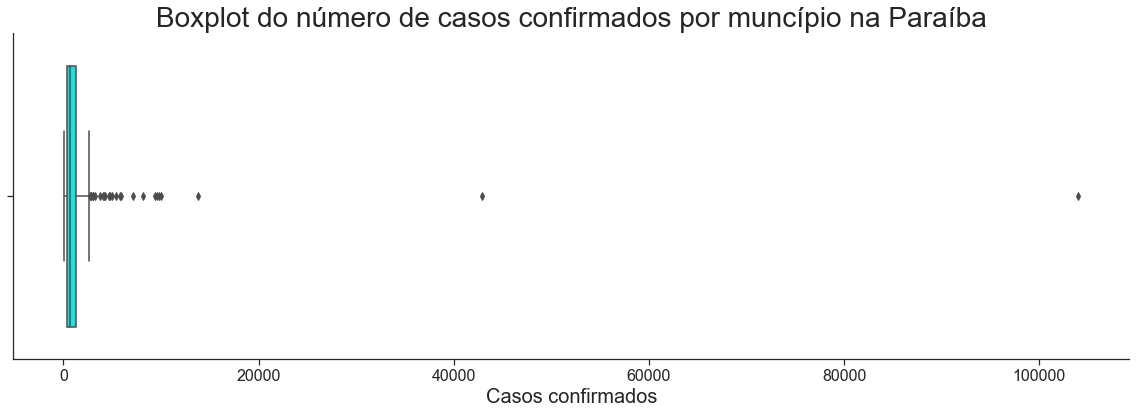

In [107]:
ax = sns.boxplot(data = casos_pb_df, x = 'confirmed', color='cyan')
ax.set_title('Boxplot do número de casos confirmados por muncípio na Paraíba', fontsize = 28)
ax.figure.set_size_inches(20, 6)
ax.set_xlabel('Casos confirmados', fontsize = 20)
ax.tick_params(labelsize = 16)

In [108]:
casos_pb_df[casos_pb_df['confirmed'] > 40000]

,date,city,confirmed,deaths,estimated_population,confirmed_per_100k_inhabitants,death_rate,pib_per_capita,n_vaccinations,demographic_density,vaccinated,vaccinated_per_100k_inhabitants,city_area
49,2021-08-22,CAMPINA GRANDE,42863,1084,411807,10408.5166,0.0253,23210.44,266264,696.02,209091,50774.027639,591.66
93,2021-08-22,JOAO PESSOA,104016,2890,817511,12723.4985,0.0278,25768.09,593097,3892.17,456643,55857.719346,210.04


O boxplot que representa a distribuição dos casos por município é extremamente achatado. Isso ocorre pois os dois maiores municípios do Estado, João Pessoa e Campina Grande, concentram muitos mais casos que os demais municípios. Além disso, mesmo não os levando em conta, ainda temos muitos casos outliers além deles. Isso nos mostra que os casos de COVID-19 no Estado da Paraíba não estão distribuídos uniformemente entre os municípios, e sim concentrados em focos. 

#### Mortes por COVID-19 confirmadas por município

In [109]:
casos_pb_df['deaths'].describe()

count     223.000000
mean       40.982063
std       208.289602
min         0.000000
25%         6.000000
50%        11.000000
75%        25.000000
max      2890.000000
Name: deaths, dtype: float64

Similarmente à quantidade de casos, a média de mortes por municípios tem média baixa, 40,97, porém desvio padrão alto, 208,29. 

Observamos que os valores mínino, e de primeiro, segundo e terceiro quartil são próximos (0, 6, 11 e 25 respectivamente), porém o valor máximo apresenta um salto enorme (2890). Vimos que poucos municípios concentram mais casos e consequentemente devem concentrar mais mortes, mas talvez outro fator para esse fenômeno possa ser o fato que municípios menores têm menos estrutura hospitalar para lidar com casos mais graves da doença, e é comum vermos esses pacientes serem transportados para municípios maiores para melhor tratamento. Dessa forma, caso o paciente venha a óbito, talvez ele seja registrado na capital, por exemplo, ao invés do seu município de origem, inflando mais esses números.

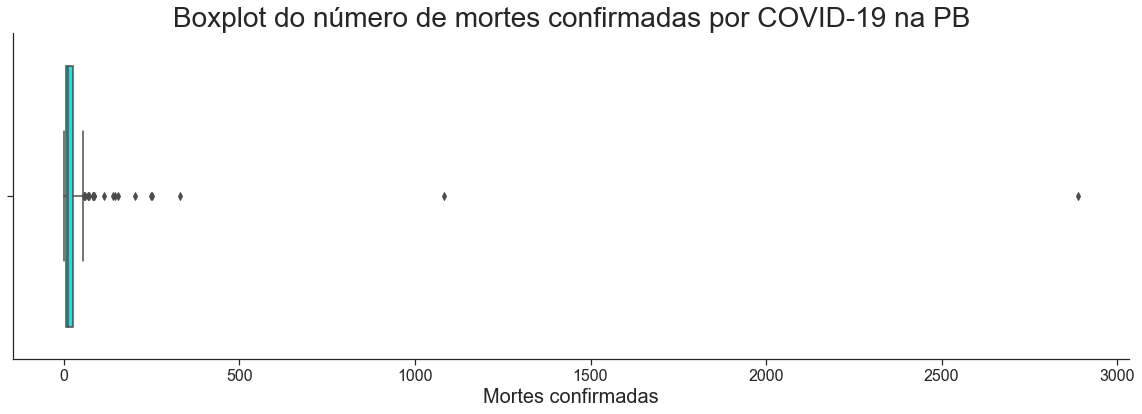

In [110]:
ax = sns.boxplot(data = casos_pb_df, x = 'deaths', color = 'cyan')
ax.set_title('Boxplot do número de mortes confirmadas por COVID-19 na PB', fontsize = 28)
ax.figure.set_size_inches(20, 6)
ax.set_xlabel('Mortes confirmadas', fontsize = 20)
ax.tick_params(labelsize = 16)

Novamente vemos um gráfico boxplot achatado, mostrando que, tal qual os casos de COVID-19, as mortes da doença também se concentram em poucos municípios outliers.

#### Casos confirmados a cada 100 mil habitantes

In [111]:
casos_pb_df['confirmed_per_100k_inhabitants'].describe()

count      223.000000
mean      9249.020478
std       3525.142735
min       1623.816000
25%       6626.868150
50%       8778.568200
75%      11430.389450
max      18192.675200
Name: confirmed_per_100k_inhabitants, dtype: float64

Quando calculamos as medidas de centralidade da quantidade de casos relativas à população de cada município, podemos fazer análises mais pontuais, que não são distorcidas pela diferença populacional. Vemos que esses dados são bem menos dispersos que os dados em quantidades absolutas.

A média de mortes a cada 100 mil habitantes é 9249.02, o desvio padrão é 3525.14, os quartis são 6626.86, 8778.56 e 11430.38. Os valores mínimo e máximo são 1623.81 e 18192.67. 

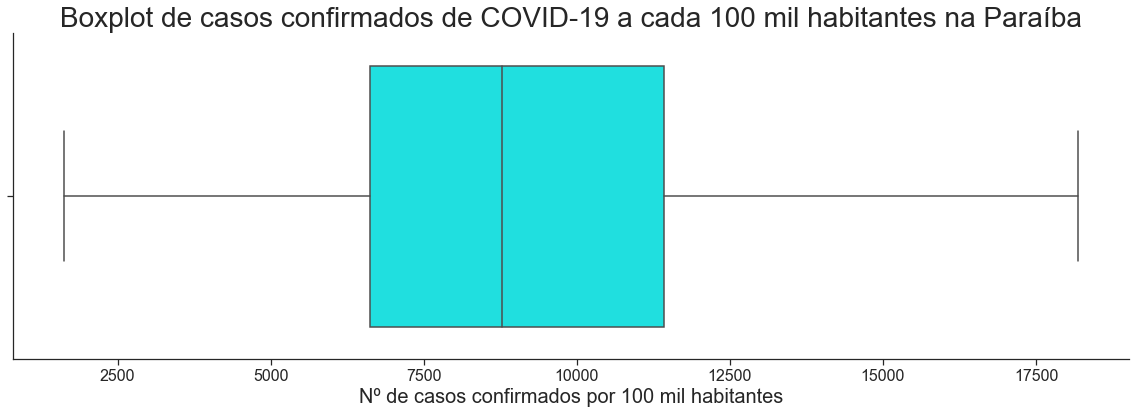

In [112]:
ax = sns.boxplot(data = casos_pb_df, x = 'confirmed_per_100k_inhabitants', color = 'cyan')
ax.set_title('Boxplot de casos confirmados de COVID-19 a cada 100 mil habitantes na Paraíba', fontsize = 28)
ax.figure.set_size_inches(20, 6)
ax.set_xlabel('Nº de casos confirmados por 100 mil habitantes', fontsize = 20)
ax.tick_params(labelsize = 16)

O boxplot dessa váriavel é muito mais legível do que o das variáveis anteriores.

#### Mortalidade da COVID-19 por município

Razão entre a quantidade absoluta de mortes e a quantidade absoluta de casos. Armazenados na coluna  `death_rate`

In [113]:
casos_pb_df['death_rate'].describe()

count    223.000000
mean       0.018597
std        0.009873
min        0.000000
25%        0.012100
50%        0.017200
75%        0.022650
max        0.066700
Name: death_rate, dtype: float64

A mortalidade média é de 0.018, o desvio padrão é 0.0098. Os quartis são 0.012, 0.017 e 0.022. O valor máximo é 0.066. 

Vemos um salto muito grande do terceiro quartil para o valor máximo. Os valores quartis ficam todos próximos à média, porém o valor máximo é 3.6 vezes maior que ela. 

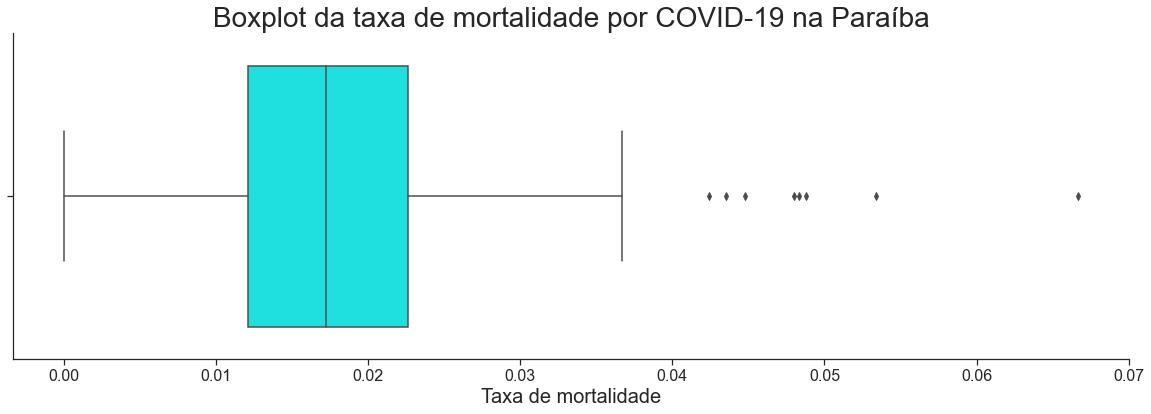

In [114]:
ax = sns.boxplot(data = casos_pb_df, x = 'death_rate', color = 'cyan')
ax.set_title('Boxplot da taxa de mortalidade por COVID-19 na Paraíba', fontsize = 28)
ax.figure.set_size_inches(20, 6)
ax.set_xlabel('Taxa de mortalidade', fontsize = 20)
ax.tick_params(labelsize = 16)

In [115]:
casos_pb_df[casos_pb_df.death_rate > 0.04]['death_rate'].count()

8

Observando o boxplot da mortalidade, vemos que há 8 municípios onde a COVID-19 foi anormalmente mais mortal do que no resto da Paraíba.

### Comparação com o cenário brasileiro

Agora, iremos analisar como esses dados da COVID-19 na Paraíba se comparam com o resto do Brasil.

In [116]:
casos_br_df.describe()

,confirmed,confirmed_per_100k_inhabitants,deaths,death_rate,estimated_population
count,5570.000000,5570.000000,5570.000000,5570.000000,5.570000e+03
mean,3619.971634,9457.720051,101.330162,0.024052,3.801718e+04
std,18542.229168,4605.463381,753.763631,0.015608,2.228930e+05
min,10.000000,178.954900,0.000000,0.000000,7.760000e+02
25%,429.000000,6077.439950,8.000000,0.014900,5.442250e+03
50%,932.500000,9011.100950,20.000000,0.021200,1.166550e+04
75%,2298.750000,12278.478300,50.000000,0.029600,2.566375e+04
max,929136.000000,46807.428100,36714.000000,0.321000,1.232523e+07


Quanto à média de casos por município, a brasileira é 3619.97 e a paraibana é 1932.32 (Paraíba bem abaixo da média nacional).

Quanto à média de mortes por município, a brasileira é 101.33 e a paraibana é 40.98 (Paraíba bem abaixo da média nacional).

Quanto à média de casos a cada 100 mil habitantes, a brasileira é 9457.72 e a paraibana é 9249.02 (Paraíba um tanto abaixo da média nacional).

Quanto à mortalidade média, a brasileira é 0.0240 e a paraibana é 0.0185 (Paraíba um tanto abaixo da média nacional).

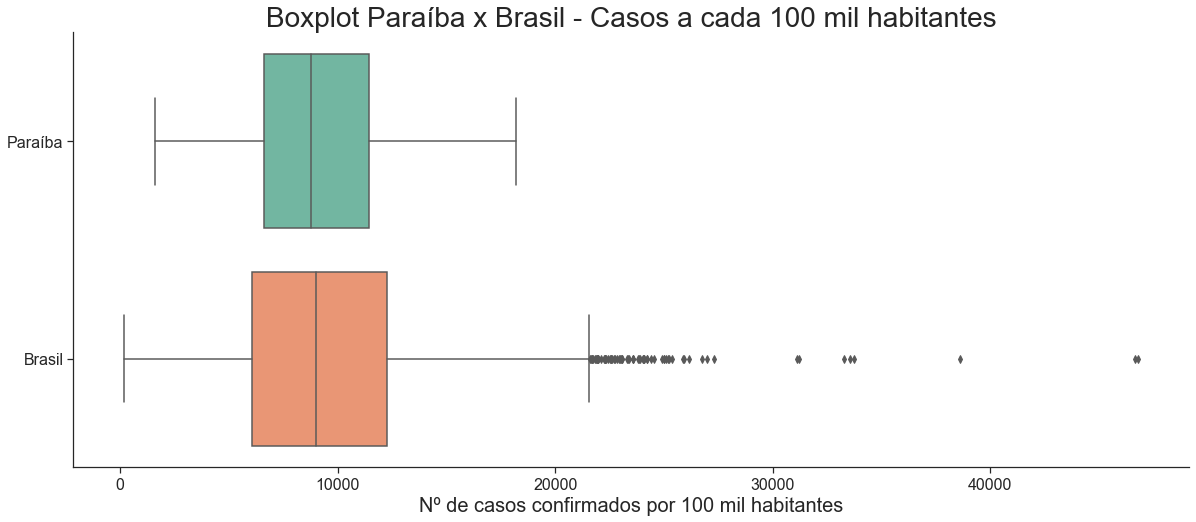

In [117]:
data_cp100k = [casos_pb_df.confirmed_per_100k_inhabitants, casos_br_df.confirmed_per_100k_inhabitants]
headers_cp100k = ['Paraíba', 'Brasil']

compare_cp100k = pd.concat(data_cp100k, axis = 1, keys = headers_cp100k)

bp_cp100k = sns.boxplot(data = compare_cp100k, orient = 'h', palette = 'Set2', order = ['Paraíba', 'Brasil'])
bp_cp100k.set_title('Boxplot Paraíba x Brasil - Casos a cada 100 mil habitantes', fontsize = 28)
bp_cp100k.set_xlabel('Nº de casos confirmados por 100 mil habitantes', fontsize = 20)
bp_cp100k.figure.set_size_inches(20, 8)
bp_cp100k.tick_params(labelsize = 16)

Vemos que, quanto aos casos a cada 100 mil habitantes, a distribuição da Paraíba ficou bem parecida com a nacional. Os valores quartis do boxplot paraibano são próximos ao do boxplot brasileiro. Porém, na Paraíba não há presença de outliers, ao contrário do outro.

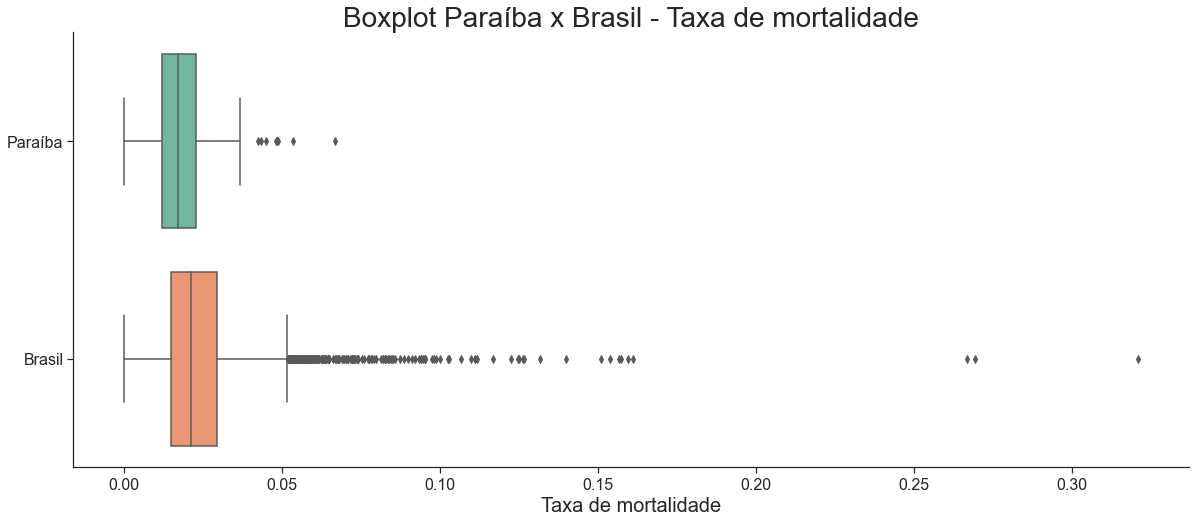

In [118]:
data_dr = [casos_pb_df.death_rate, casos_br_df.death_rate]
headers_dr = ['Paraíba', 'Brasil']

compare_dr = pd.concat(data_dr, axis = 1, keys = headers_dr)

bp_dr = sns.boxplot(data = compare_dr, orient = 'h', palette = 'Set2', order = ['Paraíba', 'Brasil'])
bp_dr.set_title('Boxplot Paraíba x Brasil - Taxa de mortalidade', fontsize = 28)
bp_dr.set_xlabel('Taxa de mortalidade', fontsize = 20)
bp_dr.figure.set_size_inches(20, 8)
bp_dr.tick_params(labelsize = 16)

Já para o boxplot da variável mortalidade, o gráfico paraibano fica um pouco mais "abaixo" do brasileiro. Porém, podemos observar a presença de municípios paraibanos que são outliers não só a nível estadual, mas também a nível nacional.

Como temos valores outliers para a mortalidade, mas não para a quantidade de casos a cada 100 mil habitantes, podemos concluir que existem na Paraíba municípios onde a mortalidade pela COVID-19 foi desproporcional à quantidade de casos.

### Agrupamento

Para entender que municípios tiveram pandemias similares, faremos seu agrupamento com o algoritmo k-means, para as variáveis _casos a cada 100 mil habitantes_ e _mortalidade_.

Primeiramente normalizamos essas duas variáveis:

In [119]:
mean_conf_p100 = np.mean(casos_pb_df['confirmed_per_100k_inhabitants'])
std_conf_p100 = np.std(casos_pb_df['confirmed_per_100k_inhabitants'])

mean_dth_rt = np.mean(casos_pb_df['death_rate'])
std_dth_rt = np.std(casos_pb_df['death_rate'])

conf_p100_norm = norm.cdf(casos_pb_df['confirmed_per_100k_inhabitants'], loc = mean_conf_p100 , scale = std_conf_p100)
dth_rt_norm = norm.cdf(casos_pb_df['death_rate'],loc = mean_dth_rt , scale = std_dth_rt)

O gráfico abaixo representa o gráfico de dispersão dos municípios paraibanos para essas duas variáveis.

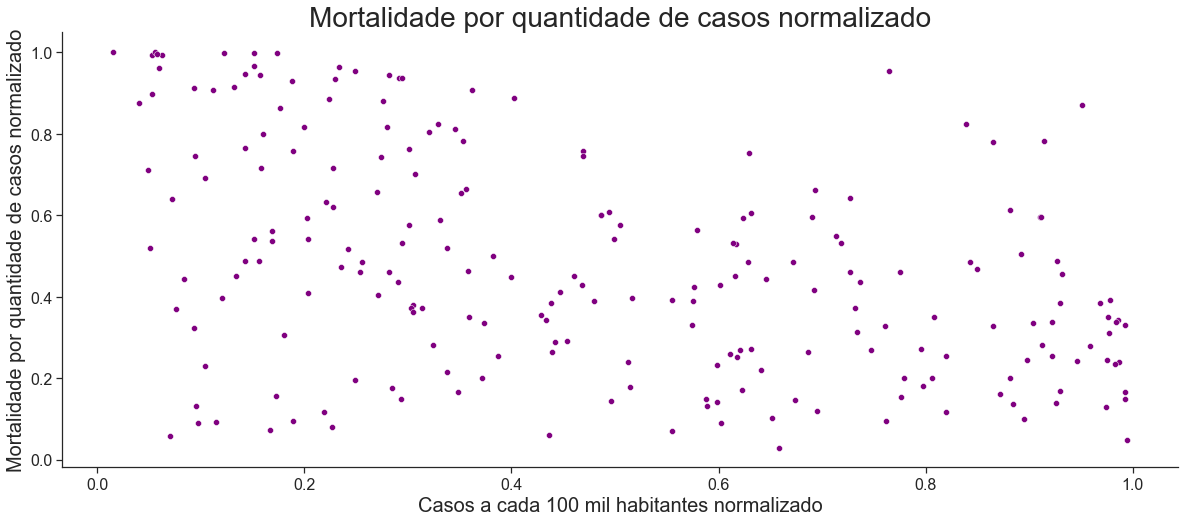

In [120]:
ax = sns.scatterplot(x = conf_p100_norm, y = dth_rt_norm, color = 'purple')
ax.set_title('Mortalidade por quantidade de casos normalizado',  fontsize = 28)
ax.set_xlabel('Casos a cada 100 mil habitantes normalizado', fontsize = 20)
ax.set_ylabel('Mortalidade por quantidade de casos normalizado', fontsize = 20)
ax.figure.set_size_inches(20, 8)
ax.tick_params(labelsize = 16)

Pelo método elbow, determinamos que uma boa quantidade de _clusters_ para a nossa anáĺise é 4.

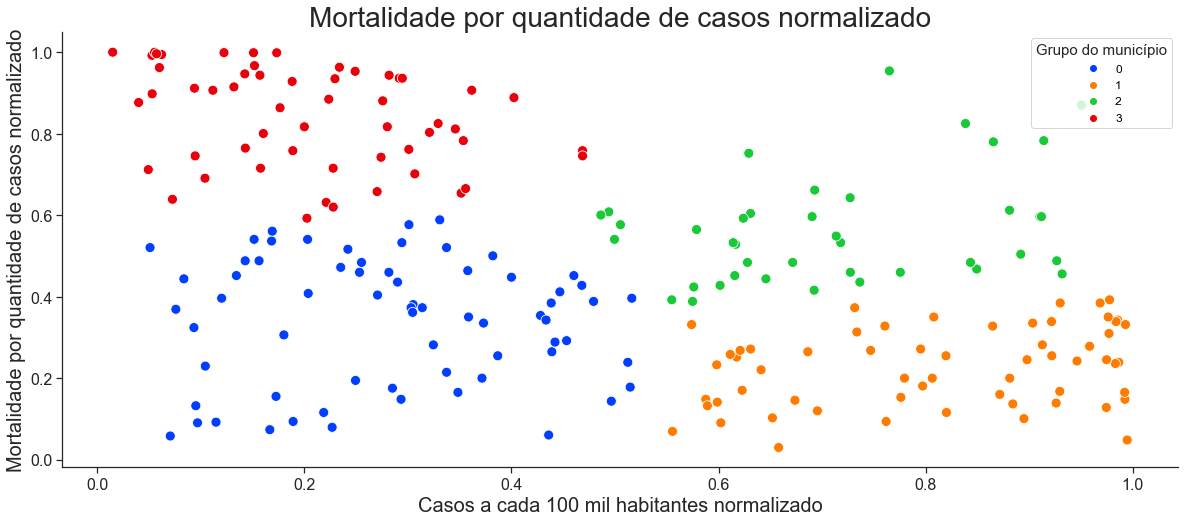

In [121]:
grouping_data = pd.DataFrame({'Casos a cada 100 mil habitantes normalizado' : conf_p100_norm, 'Mortalidade por quantidade de casos normalizado': dth_rt_norm})

kmeans = KMeans(n_clusters = 4)
kmeans.fit(grouping_data)
ax = sns.scatterplot(x = conf_p100_norm, y = dth_rt_norm, hue= kmeans.labels_, palette= 'bright', s=100)

ax.legend(
    loc='upper right', title='Grupo do município',
    title_fontsize = 15, fontsize = 12, labelcolor = 'black',
    )

ax.set_title('Mortalidade por quantidade de casos normalizado', fontsize = 28)
ax.set_xlabel('Casos a cada 100 mil habitantes normalizado', fontsize = 20)
ax.set_ylabel('Mortalidade por quantidade de casos normalizado', fontsize = 20)
ax.figure.set_size_inches(20, 8)
ax.tick_params(labelsize = 16)

O grupo 0, representado em azul no gráfico, são municípios cujos casos e mortalidade permaneceram baixos.

O grupo 1, representado laranja no gráfico, representa os municípios que possuem muitos casos por 100 mil habitantes, porém mesmo assim a mortalidade permanece baixa, comparada a outros municípios.
  
O grupo 2, representado em verde, são municípios com maior quantidade de casos e maior mortalidade. Muitas coisas podem interferir para isso ter ocorrido nsses municípios, podemos especular, por exemplo superlotação nas UTIs, devido ao maior fluxo de casos, e consequentemente pior atendimento aos casos graves.
  
O grupo 3, representado em vermelho, são os municípios que possuem poucos casos de COVID-19 em relação à população, porém a mortalidade é alta. Isso pode ocorrer devido à subnotificação de casos, possivelmente esses municípios tenderam a testar os casos mais graves da doença e nem tanto casos mais leves, de forma a inflacionar a mortalidade. Outra razão plausível pode ser uma possível deficiência de infraestrutura hospitalar para atender os casos mais graves.

### Respondendo a pergunta

A pandemia se manifestou de forma bastante diferente nos diversos municípios da Paraíba.

Para tentar entender que fatores fazem um determinado município ter mais ou menos casos e mais ou menos mortes, iremos para a próxima pergunta

## Segunda pergunta

Fatores geográficos e econômicos - como população absoluta, densidade demográfica e PIB - influenciam o quadro da COVID-19 entre os municípios paraibanos?

Para averiguar isso, faremos uma SPLOM com algumas colunas do dataset `casos_pb_df`.

Primeiramente normalizamos as variáveis.

In [122]:
casos_pb_df.head(1)

,date,city,confirmed,deaths,estimated_population,confirmed_per_100k_inhabitants,death_rate,pib_per_capita,n_vaccinations,demographic_density,vaccinated,vaccinated_per_100k_inhabitants,city_area
0,2021-08-22,AGUA BRANCA,1129,14,10306,10954.7836,0.0124,8074.16,6754,42.65,5173,50194.061712,241.66


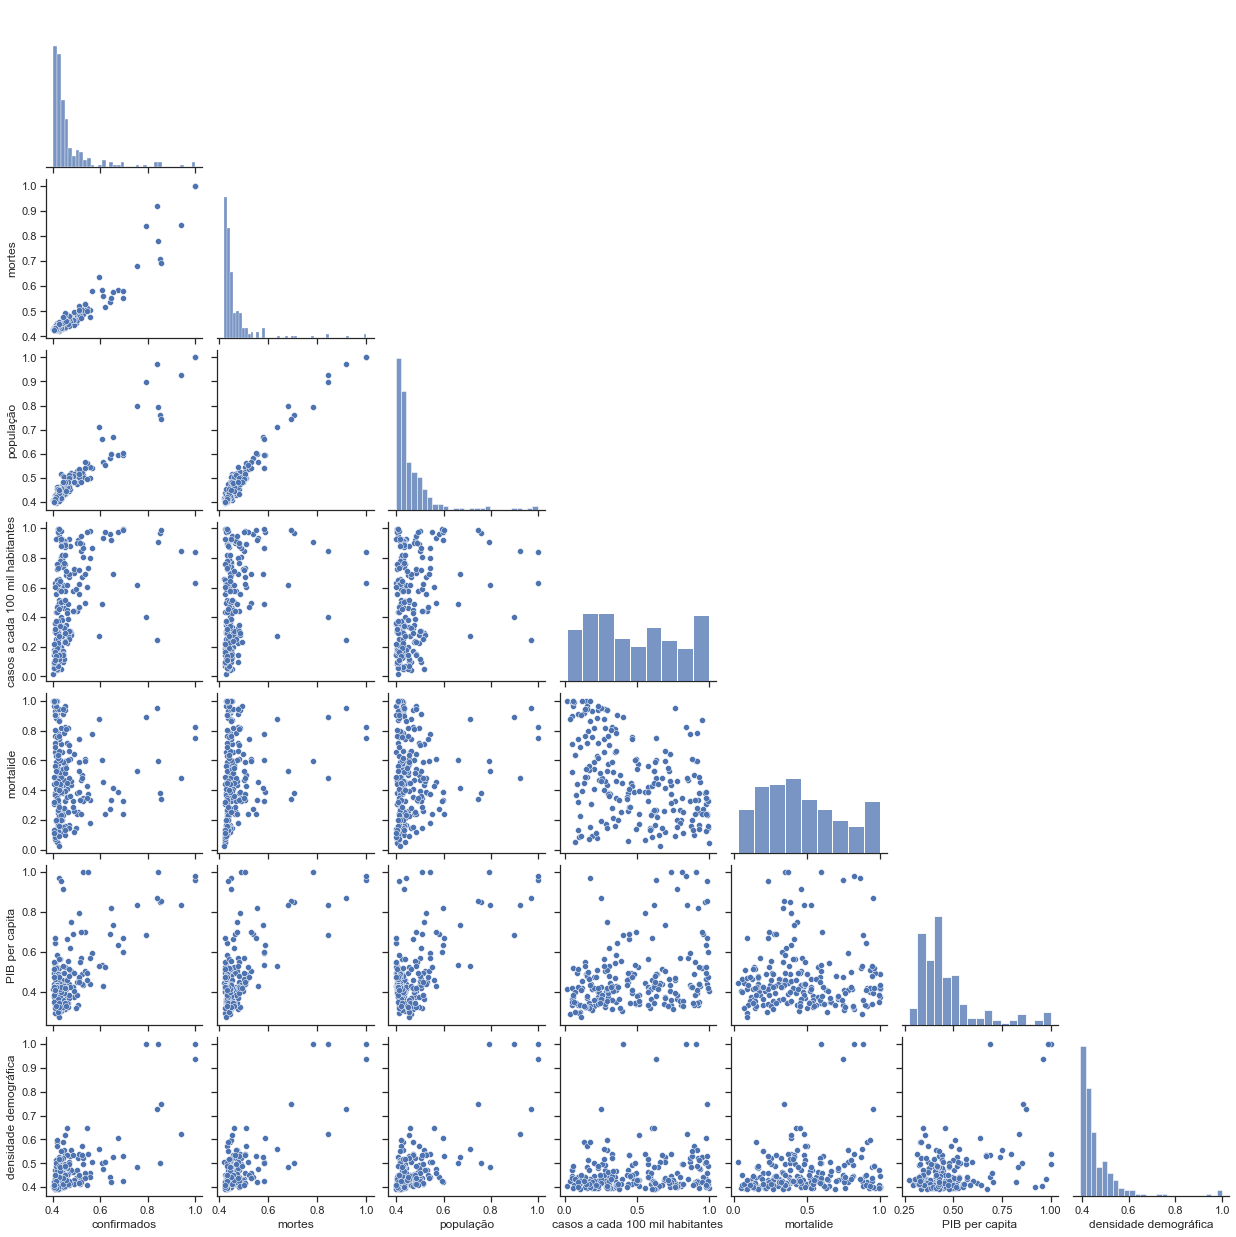

In [123]:
mean_confirmed = np.mean(casos_pb_df['confirmed'])
std_confirmed = np.std(casos_pb_df['confirmed'])

mean_deaths = np.mean(casos_pb_df['deaths'])
std_deaths = np.std(casos_pb_df['deaths'])

mean_pop = np.mean(casos_pb_df['estimated_population'])
std_pop = np.std(casos_pb_df['estimated_population'])

mean_100k = np.mean(casos_pb_df['confirmed_per_100k_inhabitants'])
std_100k = np.std(casos_pb_df['confirmed_per_100k_inhabitants'])

mean_dth_rt = np.mean(casos_pb_df['death_rate'])
std_dth_rt = np.std(casos_pb_df['death_rate'])

mean_pib = np.mean(casos_pb_df['pib_per_capita'])
std_pib = np.std(casos_pb_df['pib_per_capita'])

mean_density = np.mean(casos_pb_df['demographic_density'])
std_density = np.std(casos_pb_df['demographic_density'])

confirmed_norm = pd.Series(norm.cdf(casos_pb_df['confirmed'], loc = mean_confirmed , scale = std_confirmed))
deaths_norm = pd.Series(norm.cdf(casos_pb_df['deaths'], loc = mean_deaths, scale = std_deaths))
population_norm = pd.Series(norm.cdf(casos_pb_df['estimated_population'], loc = mean_pop, scale = std_pop))
cp100k_norm = pd.Series(norm.cdf(casos_pb_df['confirmed_per_100k_inhabitants'], loc = mean_100k, scale = std_100k))
dth_rt_norm = pd.Series(norm.cdf(casos_pb_df['death_rate'], loc = mean_dth_rt, scale = std_dth_rt))
pib_norm = pd.Series(norm.cdf(casos_pb_df['pib_per_capita'], loc = mean_pib, scale = std_pib))
density_norm = pd.Series(norm.cdf(casos_pb_df['demographic_density'], loc = mean_density, scale = std_density))

splom_columns = [confirmed_norm, deaths_norm, population_norm, cp100k_norm, dth_rt_norm, pib_norm, density_norm]
splom_headers = ["confirmados", "mortes", "população", "casos a cada 100 mil habitantes", "mortalide", "PIB per capita", "densidade demográfica"]
splom_df = pd.concat(splom_columns, axis = 1, keys = splom_headers)

sns.set_theme(style = "ticks")
sns.pairplot(splom_df, corner = True)
plt.show()

### Respondendo a pergunta

## Terceira pergunta

Como foi a adesão do povo paraibano à vacina, entre os diferentes grupos étnicos, faixas etárias, e gêneros?

### Respondendo a pergunta